<a href="https://colab.research.google.com/github/WahomeKezia/Image_Classification/blob/main/TeaLeaves_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import TensorFlow and other necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive  # To mount Google Drive
import os
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image


The dataset contains 8 sub-directories
of  common diseases of tea and class of healthy tea leaves.
```
teasicknessdataset/
   healthy/
   algal leaf /
   bird eye spot/
   gray light/
   Anthracnose/
   white spot/
   red leaf spot/
   brown blight/

```





Mounting to drive

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Uploading dataset

In [5]:
# Import necessary libraries
import os

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/Image_Classification/teasicknessdataset'


#Exploratory Data Analysis

Classes in the dataset (different tea leaf diseases)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
# Create a list to store the subdirectories (class names) in your dataset
class_names = []

# Walk through the dataset directory and retrieve subdirectories
for x in os.walk(dataset_path):
    # Get the current subdirectory path
    sub_dir = x[0]

    # Split the subdirectory path based on '/'
    sub_dir_list = str(sub_dir).split('/')

    # Check if the subdirectory is a class (based on its depth in the directory structure)
    if len(sub_dir_list) > 4:
        # Extract the class name from the subdirectory path
        x_class = sub_dir_list[-1]

        # Append the class name to the list
        class_names.append(x_class)

# Print the list of class names
print(class_names)


['teasicknessdataset', 'algal leaf', 'brown blight', 'bird eye spot', 'gray light', 'Anthracnose', 'healthy', 'red leaf spot', 'white spot']


Overview of the dataset class distribution

In [9]:
from pathlib import Path

# Assuming 'dataset_path' is the root path of your dataset
dataset_dir = Path(dataset_path)

# Print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:", image_count)

Images in class teasicknessdataset: 0
Images in class algal leaf: 113
Images in class brown blight: 113
Images in class bird eye spot: 100
Images in class gray light: 100
Images in class Anthracnose: 100
Images in class healthy: 74
Images in class red leaf spot: 143
Images in class white spot: 142


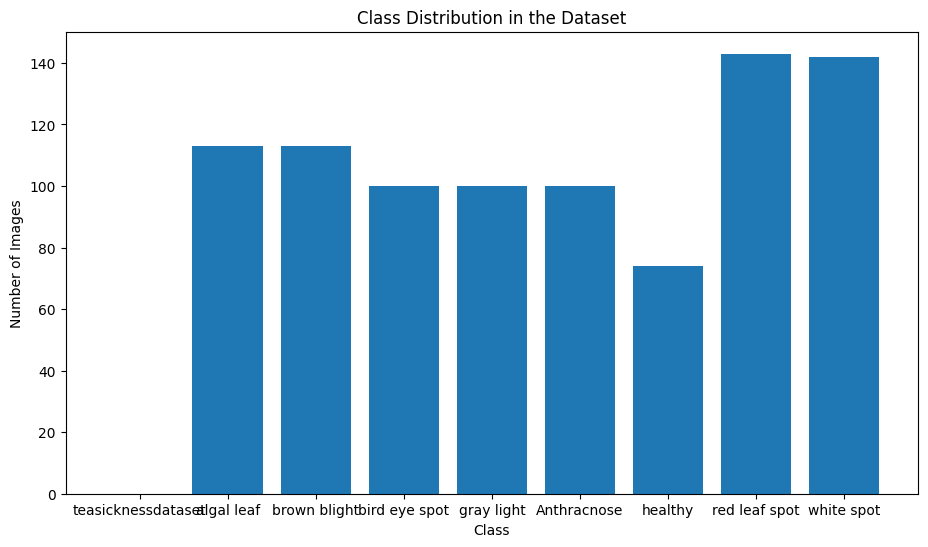

In [10]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(11, 6))
plt.bar(class_names, [len(list(dataset_dir.glob(f'{class_i}/*.jpg'))) for class_i in class_names])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()


Viewing the images from the dataset to understand the data

<Figure size 1000x500 with 0 Axes>

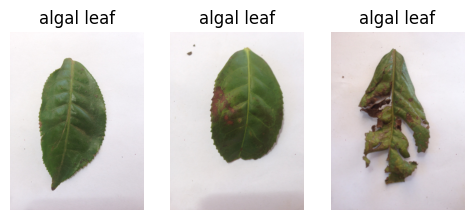

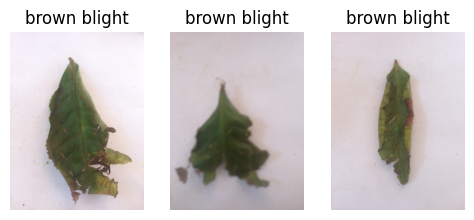

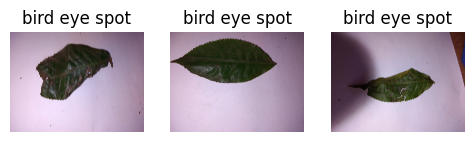

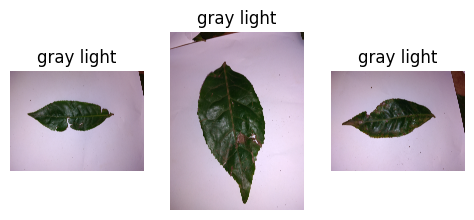

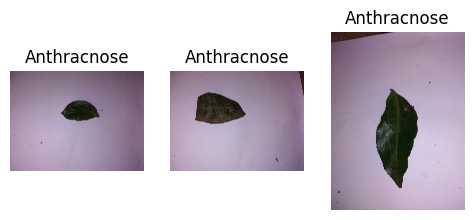

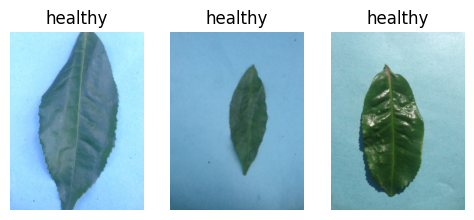

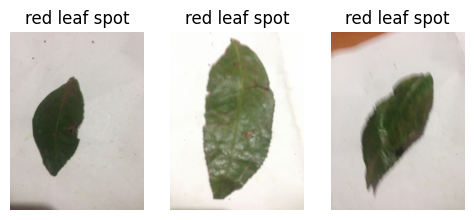

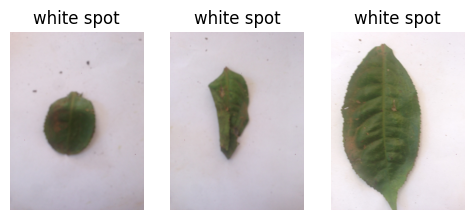

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# Visualize sample images
for class_i in class_names:
    # Get a list of paths to 3 sample images for the current class
    sample_images = list(dataset_dir.glob(f'{class_i}/*.jpg'))[:3]

    # Create a figure to display the sample images
    plt.figure(figsize=(10, 5))

    # Loop through the sample images and display them
    for i, img_path in enumerate(sample_images):
        # Create a subplot for each image
        plt.subplot(1, 5, i + 1)

        # Open the image using PIL
        img = Image.open(str(img_path))

        # Display the image
        plt.imshow(img)

        # Set the title of the subplot as the class name
        plt.title(class_i)

        # Turn off axis labels
        plt.axis('off')

    # Show the figure with the sample images for the current class
    plt.show()





Splitting my Dataset , Train and Validation




Setting parameters for training and validation

In [11]:
# Parameter setting
train_batch = 128   # Batch size for training
val_batch = 128     # Batch size for validation
img_height = 224    # Target height for resizing images
img_width = 224     # Target width for resizing images
IMG_SIZE = (img_height, img_width)  # Tuple representing the target size for images
val_split = 0.2     # Validation split ratio (20% of the data will be used for validation)




In [12]:
#Normalization using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values to be between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create a data generator for training images
batch_size = 32
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),   # Adjust size based on your model's preferred input size (if not using a pre-trained model)
    batch_size=batch_size,
    class_mode='categorical'  # sets multiple classes (categorical classification)
)


Found 885 images belonging to 8 classes.


It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

Using the image_dataset_from_directory function from TensorFlow to load the training dataset.

In [13]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,               # Path to the directory containing the dataset
    validation_split=val_split, # Percentage of data to use for validation
    subset="training",          # Specify that this is the training dataset
    seed=123,                   # Seed for reproducibility
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=train_batch      # Batch size for training
)

Found 885 files belonging to 8 classes.
Using 708 files for training.


Loading the data for validation using the image_dataset_from_directory function

In [14]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,               # Path to the directory containing the dataset
    validation_split=val_split, # Percentage of data to use for validation
    subset="validation",        # Specify that this is the validation dataset
    seed=123,                   # Seed for reproducibility
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=val_batch        # Batch size for validation
)

Found 885 files belonging to 8 classes.
Using 177 files for validation.


#Configure the training dataset for performance

Retrieving the class names from the training dataset and printing them .These correspond to the directory names in alphabetical order.

In [15]:
# Get class names from the training dataset
class_names = train_ds.class_names

# Print the class names
print(class_names)

# Determine the number of classes
num_classes = len(class_names)


['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


Reviewing the distribution of the training dataset

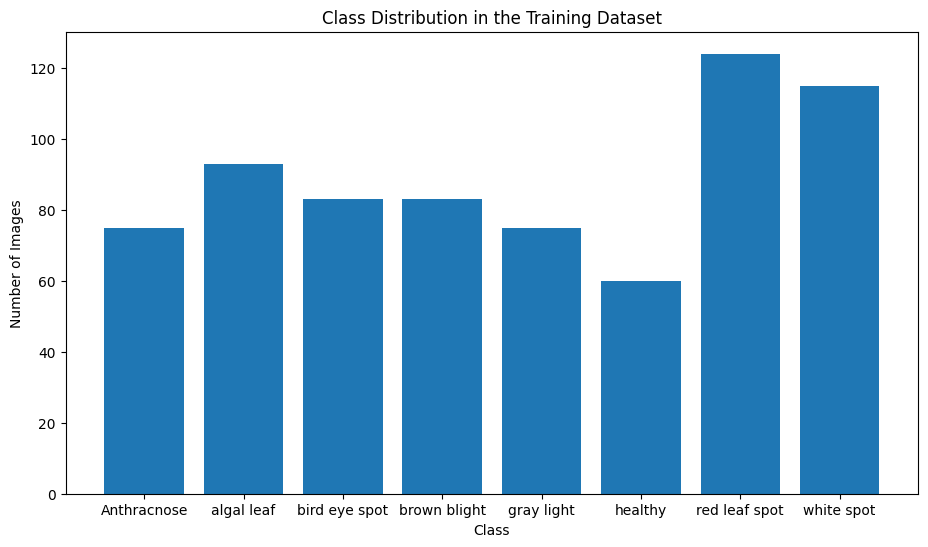

Class Counts:
Anthracnose: 75
algal leaf: 93
bird eye spot: 83
brown blight: 83
gray light: 75
healthy: 60
red leaf spot: 124
white spot: 115


In [14]:
# Get class names from the dataset
class_names = train_ds.class_names

# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the batches in the training dataset
for _, labels in train_ds:
    # Count the occurrences of each class in the batch
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Plot class distribution
plt.figure(figsize=(11, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Training Dataset')
plt.show()

# Print the class counts
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Addressing the imbalance of the classes distributions

# Preprocessing using TensorFlow's map function after splitting the data

Data augmentation, which is an excellent practice to increase the diversity of your training dataset and improve the generalization in the model

In [16]:
# Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


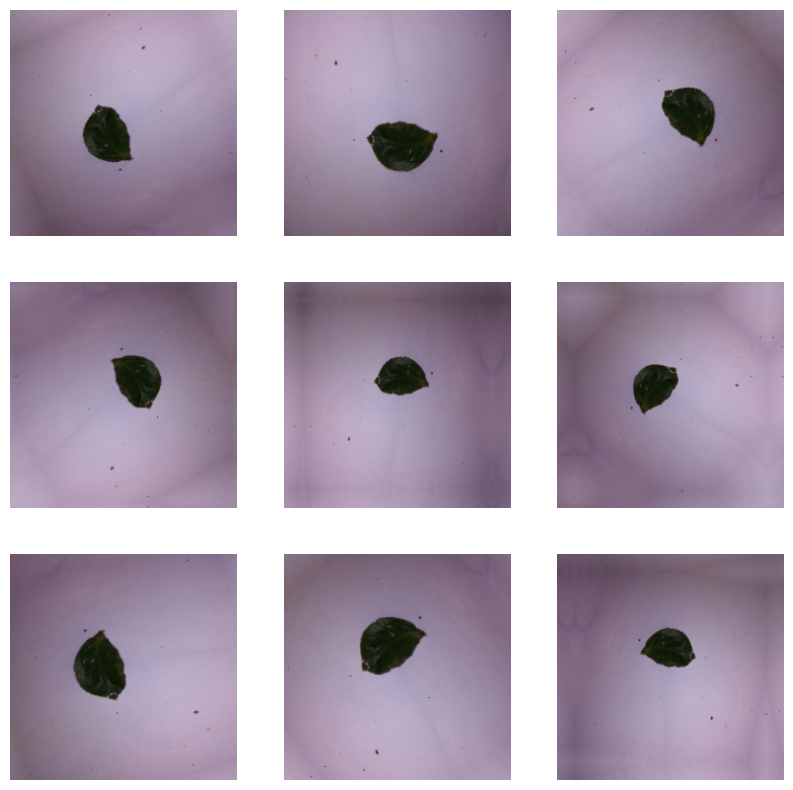

In [17]:

# Apply data augmentation to the training dataset
# train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_d= train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
# Assuming 'train_labels' is the array of labels in your training dataset
train_labels_before = np.concatenate([y for _, y in train_ds], axis=0)

# Count the number of occurrences of each class in the original training dataset
class_counts_before = [np.sum(train_labels_before == i) for i in range(len(class_names))]

# Assuming 'train_labels_augmented' is the array of labels in the augmented training dataset
train_labels_augmented = np.concatenate([y for _, y in train_ds_augmented], axis=0)

# Count the number of occurrences of each class in the augmented training dataset
class_counts_after = [np.sum(train_labels_augmented == i) for i in range(len(class_names))]

# Print class distribution before and after augmentation
print("Class Distribution Before Augmentation:")
for class_name, count in zip(class_names, class_counts_before):
    print(f"{class_name}: {count}")

print("\nClass Distribution After Augmentation:")
for class_name, count in zip(class_names, class_counts_after):
    print(f"{class_name}: {count}")


Class Distribution Before Augmentation:
Anthracnose: 75
algal leaf: 93
bird eye spot: 83
brown blight: 83
gray light: 75
healthy: 60
red leaf spot: 124
white spot: 115

Class Distribution After Augmentation:
Anthracnose: 75
algal leaf: 93
bird eye spot: 83
brown blight: 83
gray light: 75
healthy: 60
red leaf spot: 124
white spot: 115


In [18]:
from sklearn.utils.class_weight import compute_class_weight
train_labels = np.concatenate([y for _, y in train_ds], axis=0)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)


In [45]:
# Print the class counts
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Class Counts:
Anthracnose: 75
algal leaf: 93
bird eye spot: 83
brown blight: 83
gray light: 75
healthy: 60
red leaf spot: 124
white spot: 115


#Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make the input values small.

This step is essential for preparing the input data for the model. Normalizing pixel values helps in stabilizing the training process and allows the model to converge more efficiently

Here, I will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [19]:
# Define a Rescaling layer to normalize pixel values
normalization_layer = layers.Rescaling(1./255)

In [20]:
# Apply normalization to the entire training dataset using the map function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Retrieve a batch of normalized images and labels
image_batch, labels_batch = next(iter(normalized_ds))

# Extract the first normalized image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first normalized image
print("Min pixel value:", np.min(first_image))
print("Max pixel value:", np.max(first_image))

Min pixel value: 0.0
Max pixel value: 0.9939195





Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

# Apply caching, shuffling, and prefetching to the training dataset
train_ds = train_ds.cache()       # Cache the dataset for improved performance
train_ds = train_ds.shuffle(1000) # Shuffle the dataset for randomness during training
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch batches for smoother training

# Apply caching and prefetching to the validation dataset
val_ds = val_ds.cache()           # Cache the dataset for improved performance
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch batches for smoother validation


#Review the data
Here are the first nine images from the training dataset:
This ensures that the images and labels are correctly loaded and that the dataset is well-prepared for training

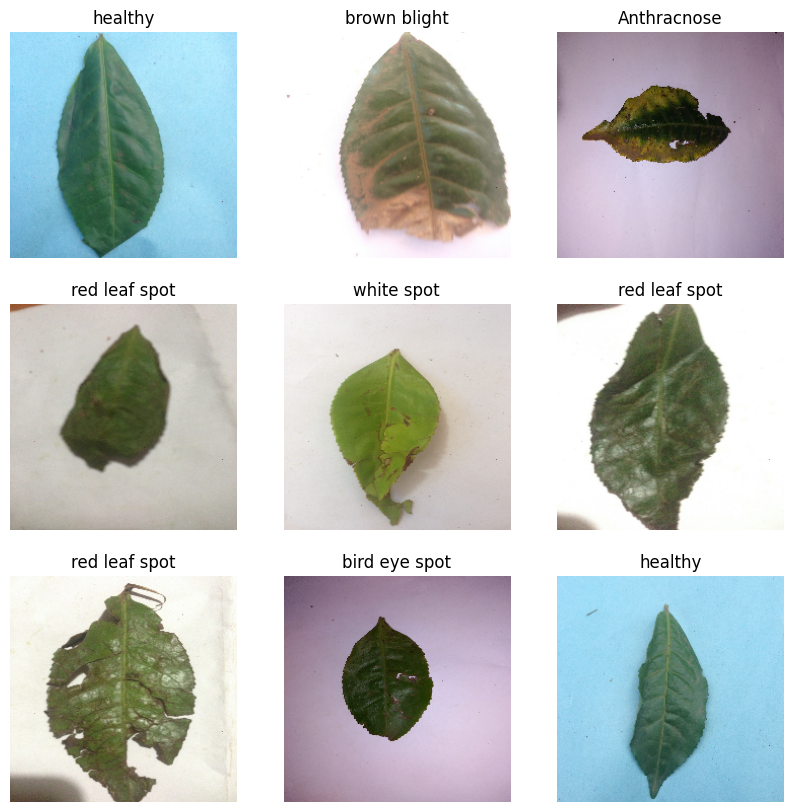

In [22]:
# Review dataset sample
plt.figure(figsize=(10, 10))

# Iterate over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Display a 3x3 grid of images
    for i in range(9):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)

        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot as the class name
        plt.title(class_names[labels[i]])

        # Turn off axis labels for better visualization
        plt.axis("off")




checking the shapes of the image and label batches in your training dataset by
iterating over batches in the training dataset and printing the shapes of the image batches and label batches.

In [23]:
# Iterate over batches in the training dataset and print batch shapes
for image_batch, labels_batch in train_ds:
    # Print the shape of the current image batch
    print("Image batch shape:", image_batch.shape)

    # Print the shape of the current labels batch
    print("Labels batch shape:", labels_batch.shape)

    # Break the loop after processing the first batch
    break


Image batch shape: (68, 224, 224, 3)
Labels batch shape: (68,)


The image_batch is a tensor of the shape `(68, 224, 224, 3)`. This is a batch of `68` images of shape `224x224x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(68,)`, these are corresponding labels to the 68 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

# Building Model(Customized)

Building a custom architecture for a convolutional neural network (CNN) for image classification. In this case, the convolutional layers themselves are responsible for feature extraction.

In [24]:
# Model architecture
model = Sequential([
    # Data augmentation layers
    data_augmentation,

    # Rescale pixel values to be in the [0,1] range
    layers.Rescaling(1./255),

    # Convolutional layers with max pooling
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten the output for dense layers
    layers.Flatten(),

    # Dense layers with dropout and batch normalization
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Output layer with the number of classes
    layers.Dense(num_classes, activation='softmax')
])


#Compile the model
To compile the model choose the` tf.keras.optimizers.Adam optimizer` and `tf.keras.losses.SparseCategoricalCrossentropy` loss function.
To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile.`

In [25]:
# compile model
learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

After running this code, the output is a table with detailed information about each layer in the model, including the number of parameters. This can be helpful for debugging and optimizing your model architecture.





In [26]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

#Train the model
Train the model for 500 epochs with the Keras `model.fit` method:
I first trained with 500 episode , then 50 , saved and downloaded the model each time ensure saved progess
Valuation loss and accuracy is still need more training  exhibiting overfitting this could be as a result of running using GPU , I had not observed this when I using the CPU runtime

In [27]:
# Train the my model
epochs = 500 # Adjust based on the experimentation

from keras.callbacks import EarlyStopping
# # Early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     patience=7,  # Number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True,
#     monitor='val_loss'  # Metric to monitor for improvement (e.g., validation loss)
# )

# Model checkpointing (optional)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
# Assuming you have already calculated and obtained class weights
class_weights_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

# Start training the model
history = model.fit(
    train_ds,                   # Training dataset
    validation_data=val_ds,     # Validation dataset for evaluation during training
    epochs=epochs,              # Number of training epochs
    verbose= 1, # Set to 2 for detailed progress updates during training
    class_weight=class_weights_dict, # Use calculated class weights
    callbacks=[model_checkpoint]  # Include the early stopping callback
)

# Save the entire model to a HDF5 file
model.save('/content/drive/MyDrive/Image_Classification/model.h5')


Epoch 1/500
6/6 [==============================] - 16s 1s/step - loss: 2.6841 - accuracy: 0.1370 - val_loss: 2.0817 - val_accuracy: 0.1412


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
6/6 [==============================] - 1s 116ms/step - loss: 2.4529 - accuracy: 0.1441 - val_loss: 2.1524 - val_accuracy: 0.1130
Epoch 3/500
6/6 [==============================] - 1s 123ms/step - loss: 2.3252 - accuracy: 0.1737 - val_loss: 2.0488 - val_accuracy: 0.2486
Epoch 4/500
6/6 [==============================] - 1s 120ms/step - loss: 2.2563 - accuracy: 0.1864 - val_loss: 1.9946 - val_accuracy: 0.2316
Epoch 5/500
6/6 [==============================] - 1s 105ms/step - loss: 2.1758 - accuracy: 0.2034 - val_loss: 2.0206 - val_accuracy: 0.2090
Epoch 6/500
6/6 [==============================] - 1s 112ms/step - loss: 1.9556 - accuracy: 0.2472 - val_loss: 1.9561 - val_accuracy: 0.3051
Epoch 7/500
6/6 [==============================] - 1s 112ms/step - loss: 1.9424 - accuracy: 0.2740 - val_loss: 1.9426 - val_accuracy: 0.2881
Epoch 8/500
6/6 [==============================] - 1s 120ms/step - loss: 1.9045 - accuracy: 0.2500 - val_loss: 1.9331 - val_accuracy: 0.3220
Epoch 9/500
6

#Visualize training results
Visualizations of training and validation accuracy as well as training and validation loss over the specified number of epochs.

Create plots of the loss and accuracy on the training and validation sets:

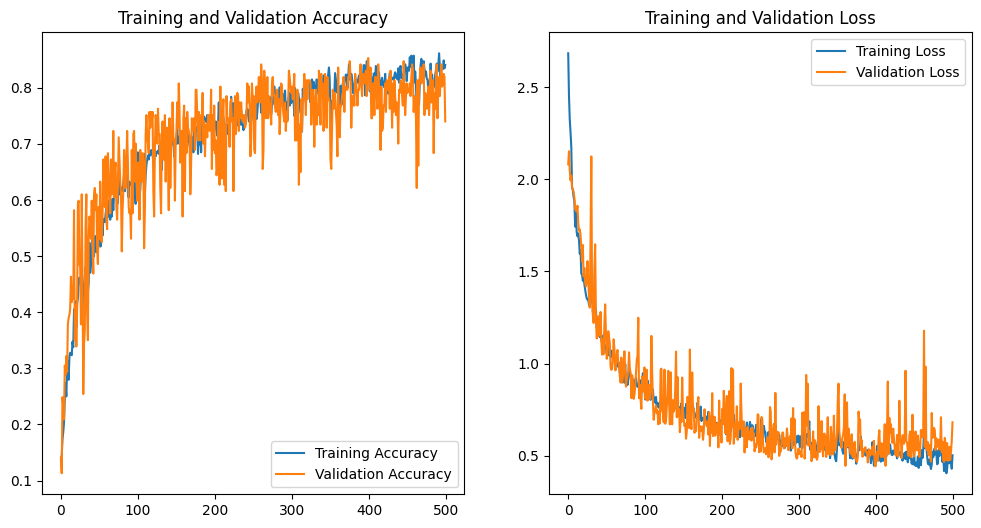

In [28]:
# Check training result with visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()


#Evaluate Model
a comprehensive evaluation of the model's performance on a batch of validation data, including detailed metrics and visualizations.

Predictions:
 [3 3 0 7 2 3 0 1 1 4 4 3 7 6 4 1 0 3 3 4 3 0 1 3 1 4 1 1 4 4 3 5 3 0 1 4 3
 1 4 4 1 7 1 4 0 4 7 0 1 1 6 0 3 4 4 7 7 1 5 0 6 4 0 4 1 7 4 6 3 5 3 7 3 2
 2 3 1 3 0 0 2 6 1 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 7 4 6 0 7 4 1 3 3 5 7 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 1 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.59      1.00      0.74        13
           2       0.67      0.36      0.47        11
           3       0.76      0.83      0.79        23
           4       0.76      0.95      0.84        20
           5       1.00      1.00      1.00         7
           6       1.00      0.53      0.70        15
           7       0.

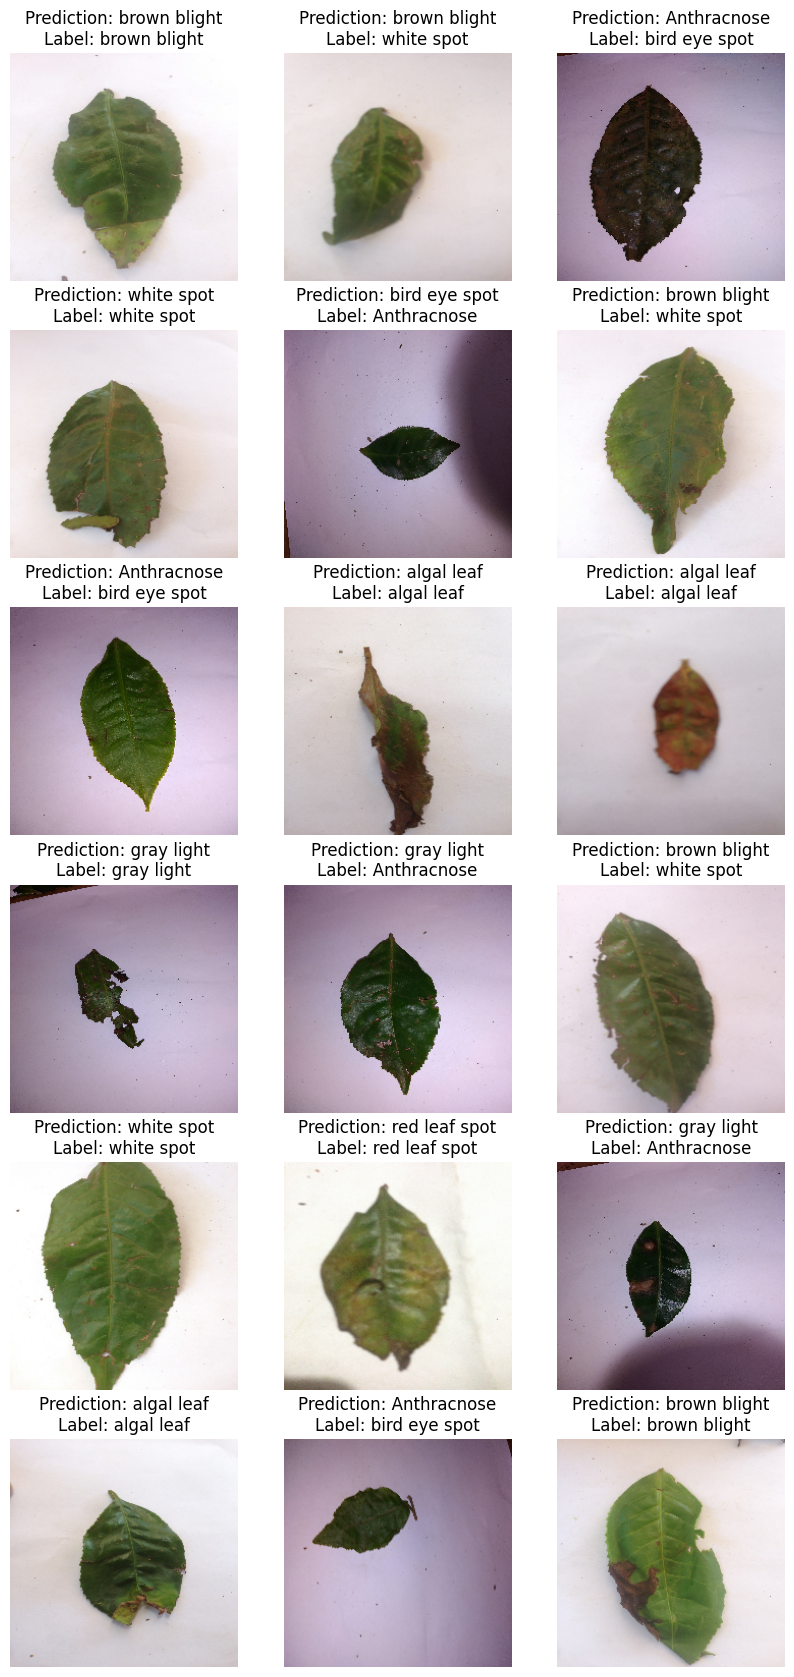

In [29]:
# Retrieve a batch of images from the test set
from sklearn.metrics import classification_report

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")


#Save Model History


In [30]:
# Create a DataFrame from the training history
history_df = pd.DataFrame(history.history)

# Save the training history to a CSV file
history_df.to_csv("history.csv")

# Display the last few entries of the training history
history_df.tail()


loss  accuracy  val_loss  val_accuracy
495  0.458858  0.833333  0.548205      0.802260
496  0.508803  0.833333  0.477132      0.807910
497  0.463379  0.848870  0.521619      0.824859
498  0.429142  0.834746  0.579597      0.819209
499  0.502091  0.840395  0.681412      0.740113